In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset

In [2]:
print(torch.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

1.10.0


In [3]:
# 模型
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layer1 = nn.Linear(10, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 784)
        self.activation = nn.ReLU()
        # self.bn1 = nn.BatchNorm1d(128)
        # self.bn2 = nn.BatchNorm1d(256)
    def forward(self, n):
        x = self.layer1(n)
        # x = self.bn1(x)
        x = self.activation(x)
        x = self.layer2(x)
        # x = self.bn2(x)
        x = self.activation(x)
        x = self.layer3(x)
        output = nn.Sigmoid()(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 2)
        self.activation = nn.ReLU()
        # self.bn1 = nn.BatchNorm1d(256)
        # self.bn2 = nn.BatchNorm1d(128)

    def forward(self, i):
        x = self.layer1(i)
        # x = self.bn1(x)
        x = self.activation(x)
        x = self.layer2(x)
        # x = self.bn2(x)
        x = self.activation(x)
        x = self.layer3(x)
        output = nn.Sigmoid()(x)
        return output

In [4]:
# testGenerator
z = torch.ones([32, 10])
model = Generator()
output = model(z)
print(output.shape)

torch.Size([32, 784])


In [5]:
# testDiscriminator
model2 = Discriminator()
output2 = model2(output)
print(output2.shape)


torch.Size([32, 2])


In [6]:
# 加载数据集

batch_size = 32
num_workers = 0

# ToTensor()将shape为(H, W, C)的nump.ndarray或img转为shape为(C, H, W)的tensor，其将每一个数值归一化到[0,1]
transform = transforms.ToTensor()

# root参数是数据存放路径，train参数是是否是训练集，transform参数是数据的转换方式
train_data = datasets.MNIST(root='D:\\Program Project\\python\\mooc-deeplearning\\实战\\dataset\\mnist_data', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='D:\\Program Project\\python\\mooc-deeplearning\\实战\\dataset\\mnist_data', train=False,
                                  download=False, transform=transform)
# 创建dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [7]:
# dataiter = iter(train_loader)
# img, label = next(dataiter)
# print(img.shape)
# print(label.shape)
# print(type(img.shape[0]))

In [8]:
Generator = Generator()
Generator.to(device)
Discriminator = Discriminator()
Discriminator.to(device)
# criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
learning_rate = 1e-5
optimizerG = optim.Adam(Generator.parameters(), lr=learning_rate)
optimizerD = optim.Adam(Discriminator.parameters(), lr=learning_rate*0.1)


In [9]:
# 训练轮次
epoch = 50
for i in range(epoch):
    # 训练
    for step, data in enumerate(train_loader, start=1):
        
        # 清空梯度
        optimizerG.zero_grad()
        optimizerD.zero_grad()
        
        # 取出数据
        images, _ = data
        # 固定G train D
        Generator.eval()
        Discriminator.train()

        # 产生高斯噪声数据
        noise = torch.normal(0, 1, (batch_size, 10))
        
        # 图片打平
        images = torch.flatten(images, start_dim=1)
        fake_img = Generator(noise.to(device))
        # Generator 产生的数据的标签为0
        fake_label = torch.zeros([batch_size], dtype=torch.long)
        imgs_label = torch.ones([batch_size], dtype=torch.long)
        total_img = torch.cat((fake_img, images.to(device)), dim=0)
        total_label = torch.cat((fake_label, imgs_label), dim=0)
        outputs = Discriminator(total_img.to(device))
        # print(outputs.shape)
        # print(total_label.shape)
        lossD = criterion(outputs, total_label.to(device))
        lossD.backward()
        optimizerD.step()
        
        # 固定住D，训练G
        Discriminator.eval()
        Generator.train()
        # 产生高斯噪声数据
        noise = torch.normal(0, 1, (batch_size, 10))
        fake_img = Generator(noise.to(device))
        outputs = Discriminator(fake_img.to(device))
        outputs = nn.Softmax()(outputs)
        # print(outputs.shape)
        lossG = -outputs[:, 1].sum()
        lossG.backward()
        optimizerG.step()
    
    print('epoch: %d--lossD: %.3f, lossG: %.3f.' % (i, lossD, lossG))
    

D:\programs\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 0--lossD: 1.286, lossG: -24.383.
epoch: 1--lossD: 0.800, lossG: -18.669.
epoch: 2--lossD: 0.510, lossG: -15.339.
epoch: 3--lossD: 0.444, lossG: -12.900.
epoch: 4--lossD: 0.322, lossG: -10.840.
epoch: 5--lossD: 0.368, lossG: -10.396.
epoch: 6--lossD: 0.447, lossG: -13.119.
epoch: 7--lossD: 0.378, lossG: -11.327.
epoch: 8--lossD: 0.271, lossG: -8.400.
epoch: 9--lossD: 0.298, lossG: -8.074.
epoch: 10--lossD: 0.473, lossG: -10.886.
epoch: 11--lossD: 0.366, lossG: -12.119.
epoch: 12--lossD: 0.552, lossG: -9.096.


KeyboardInterrupt: 

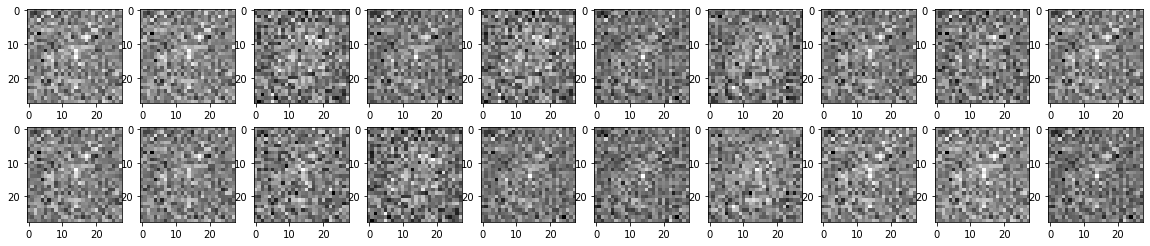

In [11]:
import matplotlib.pyplot as plt

Generator.eval()

noise = torch.normal(0, 1, (20, 10))

fake_imgs = Generator(noise.to(device))

outputs = Discriminator(fake_imgs)

# print(output)

# print(fake_img.shape)

imgs = fake_imgs.view([20, 28, 28])
imgs = imgs.cpu().detach().numpy()
# print(imgs.shape)

scale = 2
num_cols = 10
num_rows = 2

figsize = (num_cols * scale, num_rows * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
for i in range(num_rows):
    for j in range(num_cols):
        axes[i][j].imshow(imgs[i * num_cols + j], cmap='gray')
plt.show()
